In [ ]:
#-------------------------------------------------------------------------------
#Implement a CNN with PyTorch for the CIFAR-10 dataset.
#-------------------------------------------------------------------------------

In [ ]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
 
import torch.nn as nn
import torch.nn.functional as F
 
import torch.optim as optim
 
import time
import datetime
 
import matplotlib.pyplot as plt

In [ ]:
#data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Conv
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.drop2d = nn.Dropout2d(0.05)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.batchn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        
        #FC
        self.fc1 = nn.Linear(4096, 1024)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
 
    def forward(self, x):
        #Conv
        x = self.batchn1(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.batchn3(F.relu(self.conv3(x)))
        x = self.drop2d(self.pool(F.relu(self.conv4(x))))

        x = self.batchn5(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        #Flatten
        x = x.view(-1, 4096)

        #FC
        x = F.relu(self.drop(self.fc1(x)))
        x = F.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        return x
 
net = Net() #instantiate a net object

#cuda
net = net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))

In [ ]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#aux functions
def calculateAcc(dataset):
    #forward pass to compute test accuracy on every epoch
    correct = 0
    total = 0
    with torch.no_grad():
      for data in dataset:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
 
    return accuracy

[0] loss: 1.440 | Train Accuracy: 63.04 % | Test Accuracy: 61.21 %
[1] loss: 0.921 | Train Accuracy: 74.71 % | Test Accuracy: 71.96 %
[2] loss: 0.717 | Train Accuracy: 79.92 % | Test Accuracy: 75.05 %
[3] loss: 0.590 | Train Accuracy: 83.86 % | Test Accuracy: 78.02 %
[4] loss: 0.490 | Train Accuracy: 87.68 % | Test Accuracy: 80.19 %
[5] loss: 0.415 | Train Accuracy: 88.95 % | Test Accuracy: 80.58 %
[6] loss: 0.354 | Train Accuracy: 91.07 % | Test Accuracy: 80.74 %
[7] loss: 0.295 | Train Accuracy: 92.54 % | Test Accuracy: 81.17 %
[8] loss: 0.253 | Train Accuracy: 94.01 % | Test Accuracy: 81.35 %
[9] loss: 0.213 | Train Accuracy: 94.76 % | Test Accuracy: 81.86 %
Finished Training. It took  0:25:51.882888


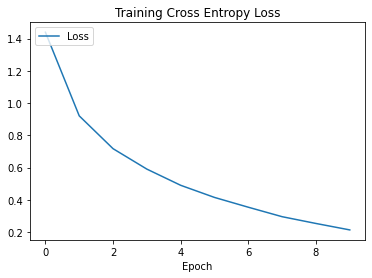

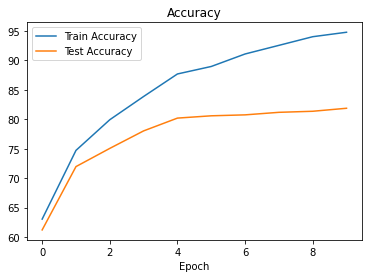

In [ ]:
#training and results
 
nepochs = 10;
minepochs = 3; #minimum number of epochs before Early Stopping
 
t = time.time()
hh = [] #list to save the training loss in every epoch
train_ac = [] #list to save the train accuracy in every epoch
test_ac = [] #list to save the test accuracy in every epoch
 
for epoch in range(nepochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
 
        inputs = inputs.cuda()
        labels = labels.cuda()
 
        # zero the parameter gradients
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        #Accumulate loss:
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
 
    #calculate accuracy for training and test sets
    train_accuracy = calculateAcc(trainloader)
    test_accuracy = calculateAcc(testloader)
    
    #save and print loss, train accuracy and test accuracy for every epoch
    hh.append(running_loss)
    train_ac.append(train_accuracy)
    test_ac.append(test_accuracy)
    print('[%d] loss: %.3f | Train Accuracy: %.2f %% | Test Accuracy: %.2f %%' % (epoch, running_loss, train_accuracy, test_accuracy)) 
    
    #Early Stopping condition
    if (epoch)>=minepochs:
      if (test_ac[-1])<=(test_ac[-2]):
        if (test_ac[-1])<=(test_ac[-3]):
          if (test_ac[-1])<=(test_ac[-4]):
            print('Early-Stoping is applied.')
            break
 
#when training ends, show a message to inform the time necessary to complete the training
elapsed = time.time() - t
elapsed = str(datetime.timedelta(seconds=elapsed))
print('Finished Training. It took ', elapsed)
 
#plot the training loss function
plt.plot(hh, label='Loss')
plt.title('Training Cross Entropy Loss')
plt.ylabel('')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()
 
#plot the test accuracy
plt.plot(train_ac, label='Train Accuracy')
plt.plot(test_ac, label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()